# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as rd

# Functions

# Main

2025-07-13 22:38:55,535 - INFO - system created with 3 particles
2025-07-13 22:38:55,537 - INFO - system created with 3 particles


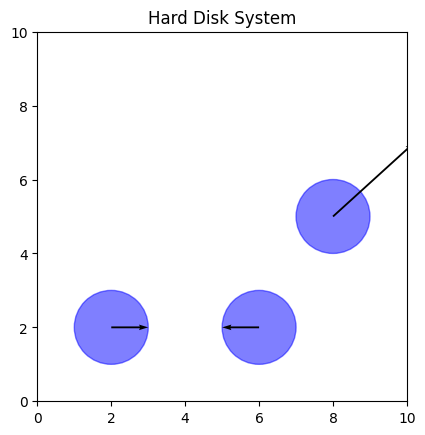

In [2]:
from base.systems import HardDiskSystem
box_size = 10
n_particles = 3
particle_radius = 1
system_a = HardDiskSystem(
    box_size = box_size, 
    n_particles=n_particles,
    particle_radius=particle_radius, 
    periodic_boundary = False
)

system_a.positions = np.array([[2.,2.], [6.,2.], [7.,5.]])
system_a.velocities = np.array([[1.,0.2], [-1.,0.2], [2.,0.2]])

system_b = HardDiskSystem(
    box_size = box_size, 
    n_particles=n_particles,
    particle_radius=particle_radius, 
    periodic_boundary = False
)

system_b.positions = np.array([[2.,2.], [6.,2.], [8.,5.]])
system_b.velocities = np.array([[1.,0.], [-1.,0.], [2.2,2.]])
# system_b.positions = np.array([[2.,2.], [6.,2.]])
# system_b.velocities = np.array([[1.,0.], [-1.,0.]])
system_b.plot_system()


In [ ]:
from base.simulations import BoundarySimulation
from copy import deepcopy
test_sim = BoundarySimulation(deepcopy(system_b))
# test_sim.run(n_steps=3)

2025-07-13 22:38:55,632 - INFO - Simulation enviorment with aperiodic boundary created.
2025-07-13 22:38:55,632 - INFO - running simulation from 0 to 1.5 in 0.5


TypeError: 'NoneType' object is not callable

In [ ]:
def update_velocitie(sim, i, j):
    xi = sim.system.positions[i]
    xj = sim.system.positions[j]
    dx = xi - xj

    vi = sim.system.velocities[i]
    vj = sim.system.velocities[j]
    dv = vi - vj

    e = dx / np.sqrt(np.dot(dx,dx))
    magnitude_change = np.dot(e, dv)
    vi_linha = vi - magnitude_change * e
    vj_linha = vj + magnitude_change * e

    sim.system.velocities[i] = vi_linha
    sim.system.velocities[j] = vj_linha

def next_wall_colision(sim):
    pos_mask = sim.system.velocities > 0
    neg_mask = sim.system.velocities < 0

    #set the direction mask
    t_plus = np.full_like(sim.system.positions, np.inf)
    t_neg = np.full_like(sim.system.positions, np.inf)

    #calculate the time of colision in each direction
    pos_dis = sim.system.box_size - sim.system.particle_radius - sim.system.positions[pos_mask]
    t_plus[pos_mask] = pos_dis / sim.system.velocities[pos_mask]
    neg_dis = sim.system.positions[neg_mask] - sim.system.particle_radius
    t_neg[neg_mask] = neg_dis / -sim.system.velocities[neg_mask]

    #set the minimun colision time in each dimension for the particles
    times = np.minimum(t_neg, t_plus)
    #wall that was hitted (0 for colision in y and 1 for colision in x)
    wall_hit = np.argmin(times,axis=1)
    hit_times = times[np.arange(sim.system.n_particles), wall_hit]
    colided_particle = np.argmin(hit_times)
    wall_colided = wall_hit[colided_particle]
    next_colision_time = min(hit_times)
    return wall_colided, colided_particle, next_colision_time


In [ ]:
def step(sim, ax = None):
    #calculate next pair colision
    particles, pair_colision_at = sim._next_pair_colision()
    to_particles_colide = pair_colision_at - sim.time

    #calculate next wall colision
    wall_colide, particle_colided, to_colide_wall = next_wall_colision(sim)

    #what comes first?
    next_event_is_wall = to_colide_wall < to_particles_colide
    if next_event_is_wall:
        # print(f'particle {particle_colided} colide with wall {'y' if wall_colide == 0 else 'x'}')
        # print("particle involved: ", particle_colided)
        # print("wall involved: ", 'y' if wall_colide == 0 else 'x')
        # print("colision occur in: ", to_colide_wall)

        sim._update_position(to_colide_wall)
        sim.system.velocities[particle_colided][wall_colide] *= -1
        sim.time += to_colide_wall
    else:
        # print(f"particle {particles[0]} colide with {particles[1]}")
        # print("particles involved: ", particles)
        # print("colision occur in: ", pair_colision_at)
        sim._update_position(to_particles_colide)
        update_velocitie(sim,*particles)
        sim.time = pair_colision_at

In [ ]:

# build simulation object
simulation_system_a = deepcopy(system_a)
# simulation_system_b = deepcopy(system_b)

simulation_time = 5
sim_a = BoundarySimulation(simulation_system_a, debug=False)

2025-07-13 22:37:05,878 - INFO - Simulation enviorment with aperiodic boundary created.


In [5]:
def particle_density(sim:BoundarySimulation, strip_count = 10):
    strip_size = sim.system.box_size / strip_count
    strips = np.arange(strip_count) * strip_size
    strip_contribution = []
    for strip in strips:
        is_inside = (sim.system.positions[:,1] >= strip) * (sim.system.positions[:,1] < strip + strip_size)
        # velocitie_mod = np.abs(sim.system.velocities[is_inside,1])
        factor = np.sum(is_inside)
        strip_contribution.append(factor)
    sim.strip_density += strip_contribution

In [ ]:
box_size = 10
dt = 0.5
n_steps = 1*1e4
strip_count = 500
strip_size = box_size / strip_count
n_particles_small = 4
n_particles_big = 64
overall_density = 0.18
sqr_r = (overall_density*box_size**2) / 3.1415

small_system = HardDiskSystem(box_size=box_size,particle_radius=np.sqrt(sqr_r/n_particles_small),n_particles=n_particles_small)
big_system = HardDiskSystem(box_size=box_size, particle_radius=np.sqrt(sqr_r/n_particles_big), n_particles=n_particles_big)

sim_small_system = BoundarySimulation(deepcopy(small_system),dt=dt)
sim_big_system = BoundarySimulation(deepcopy(big_system),dt=dt)

sim_small_system.strip_density = np.arange(strip_count) * 0.
sim_small_system.run(n_steps=n_steps,fn=lambda x: particle_density(x,strip_count=strip_count))
sim_small_system.strip_density /= (n_steps*strip_size)

sim_big_system.strip_density = np.arange(strip_count) * 0.
sim_big_system.run(n_steps=n_steps,fn=lambda x: particle_density(x,strip_count=strip_count))
sim_big_system.strip_density /= (n_steps*strip_size)


2025-07-13 22:39:41,509 - INFO - system created with 4 particles
2025-07-13 22:39:41,516 - INFO - system created with 64 particles
2025-07-13 22:39:41,517 - INFO - Simulation enviorment with aperiodic boundary created.
2025-07-13 22:39:41,518 - INFO - Simulation enviorment with aperiodic boundary created.
2025-07-13 22:39:41,519 - INFO - running simulation from 0 to 5000.0 in 0.5
2025-07-13 22:39:58,419 - INFO - running simulation from 0 to 5000.0 in 0.5


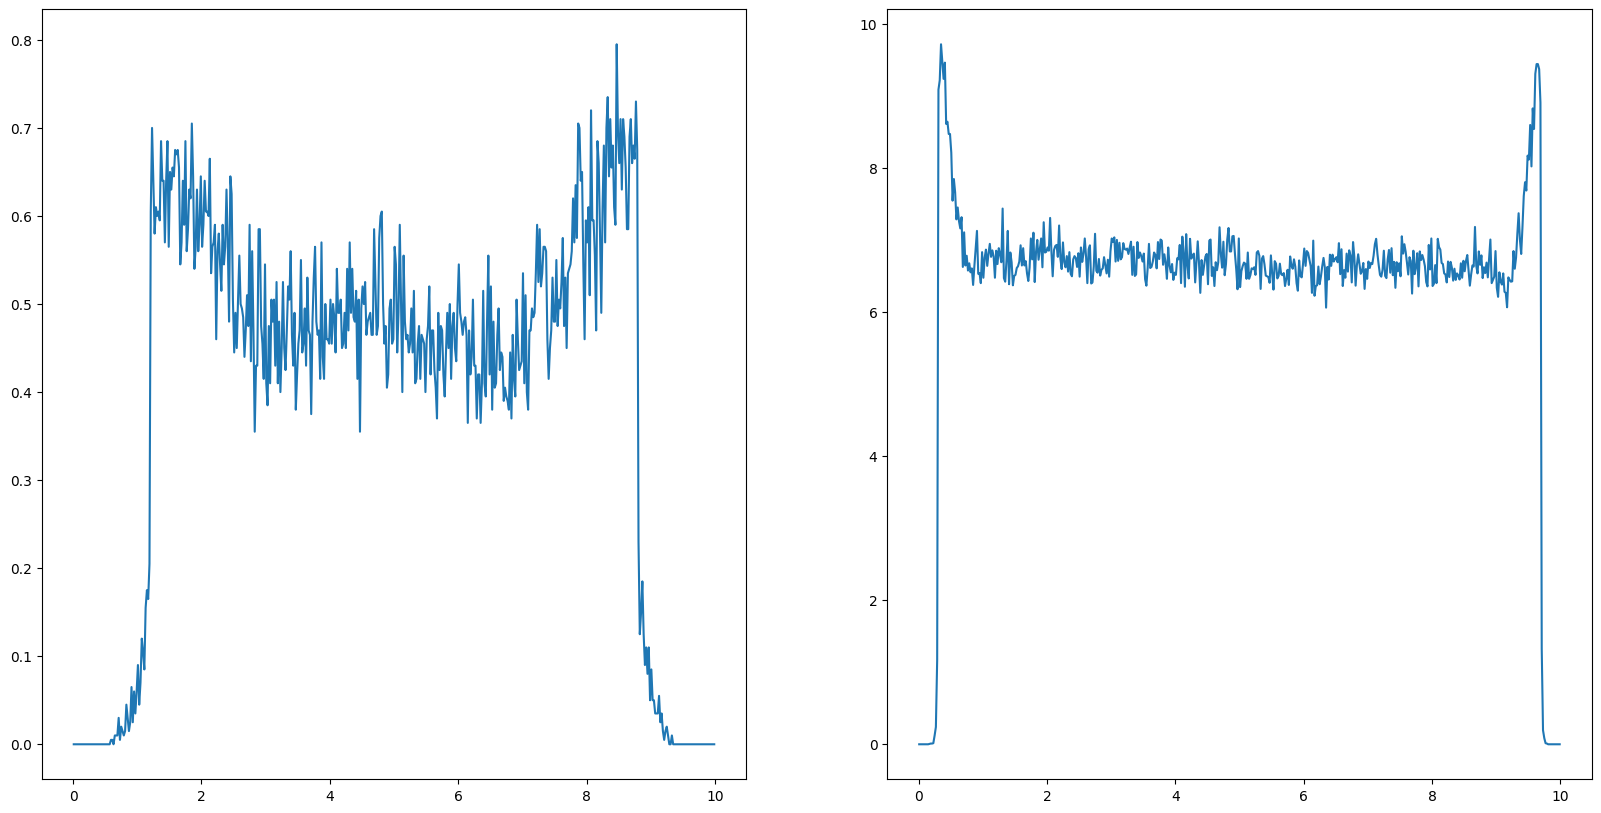

In [ ]:

strip_centers = (np.arange(strip_count) * strip_size) + (strip_size / 2)
fig, axes = plt.subplots(1,2,figsize=(20,10))
axes[0].plot(strip_centers, sim_small_system.strip_density, linestyle='-')
axes[1].plot(strip_centers, sim_big_system.strip_density, linestyle='-')